# AAI-521 Group 6 Group Project

# herpeton

## Colab Friendly Notebook

### 1 Environment Setup

In [9]:
#@title 1a) Environment Setup
import pandas as pd
import numpy as np
import hashlib
import io
import os
import sys
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
!pip install imagehash
import imagehash
from tqdm import tqdm

import matplotlib.pyplot as plt
# Show plots inline
%matplotlib inline

!pip install squarify > /dev/null
import squarify

!pip install plotly > /dev/null
import plotly.express as px

!pip install wordcloud > /dev/null
from wordcloud import WordCloud

from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 142.9 MB/s eta 0:00:00


In [10]:
#@title 1b) Mount Google Drive
CURATE_TO_DRIVE = True

if CURATE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_OUT = "/content/drive/MyDrive/herpeton/data/biotrove_train"
else:
    BASE_OUT = "/content/herpeton"

os.makedirs(BASE_OUT, exist_ok=True)

# Controls to keep runtime reasonable
MAX_RECORDS = 15000          # hard cap across the stream (increase if you have time/compute)
SAMPLE_PER_SPECIES = 50      # images per species to collect/curate/EDA
REPORT_DIR = os.path.join(BASE_OUT, "_reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"Output base: {BASE_OUT}")
print(f"Reports   : {REPORT_DIR}")
print(f"Limits    : MAX_RECORDS={MAX_RECORDS}, SAMPLE_PER_SPECIES={SAMPLE_PER_SPECIES}")

Mounted at /content/drive
Output base: /content/drive/MyDrive/herpeton/data/biotrove_train
Reports   : /content/drive/MyDrive/herpeton/data/biotrove_train/_reports
Limits    : MAX_RECORDS=15000, SAMPLE_PER_SPECIES=50


### 5 Models

In [33]:
#@title 5a) Environment Setup
!pip -q install timm

import os
import math
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch import amp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler, autocast

import torchvision.transforms as T

from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import timm
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [34]:
#@title 5b) Mount Drive & Load Metadata
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

metadata_path = (
    "/content/drive/MyDrive/herpeton//data/biotrove_train/reptilia_dataset_processed.csv"
)

BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")


df = pd.read_csv(metadata_path)
print("Metadata shape:", df.shape)
df.head()

Mounted at /content/drive
Metadata shape: (18750, 16)


,photo_id,scientificName,kingdom,phylum,class,order,family,genus,species,common_name,taxonRank,photo_url,split,image_path_fixed,width,height
0,483440,Agkistrodon laticinctus,Animalia,Chordata,Reptilia,Squamata,Viperidae,Agkistrodon,laticinctus,Broad-banded Copperhead,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,480.0,358.0
1,345778,Sceloporus uniformis,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,uniformis,Yellow-backed Spiny Lizard,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,353.0
2,181353,Pantherophis spiloides,Animalia,Chordata,Reptilia,Squamata,Colubridae,Pantherophis,spiloides,Gray Ratsnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,373.0,500.0
3,35083,Lampropeltis triangulum,Animalia,Chordata,Reptilia,Squamata,Colubridae,Lampropeltis,triangulum,Eastern Milksnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,376.0
4,261176,Imantodes cenchoa,Animalia,Chordata,Reptilia,Squamata,Colubridae,Imantodes,cenchoa,Blunthead Tree Snake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,337.0


In [35]:
#@title 5c) Encode Labels & Train/Val Split
# Use 'species' as label
assert "species" in df.columns, "Expected 'species' column in metadata."
assert "image_path_fixed" in df.columns, "Expected 'image_path_fixed' column with image paths."

# Encode species as integer labels
df["label_id"], label_names = pd.factorize(df["species"])
num_classes = len(label_names)
print("Number of classes:", num_classes)

# Split data using the 'split' column
train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

# Filter out rows with NaN in 'image_path_fixed' column for each split
train_df = train_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
val_df = val_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
test_df = test_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Number of classes: 528
Train size: 13879
Val size: 1982
Test size: 1753


In [36]:
#@title 5d) Dataset & Transforms
class ReptiliaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["image_path_fixed"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


# Image size compatible with ResNet50
image_size = 224

train_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.02,
        ),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

val_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

train_dataset = ReptiliaDataset(train_df, transform=train_transform)
val_dataset = ReptiliaDataset(val_df, transform=val_transform)
test_dataset = ReptiliaDataset(test_df, transform=val_transform)

In [37]:
#@title 5e) Dataloaders

# Requested batch size:
requested_batch_size = 64

BATCH_SIZE = requested_batch_size

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
len(train_loader), len(val_loader), len(test_loader)


(217, 31, 28)

In [38]:
from torch.optim.lr_scheduler import LambdaLR
from torch import amp

def create_warmup_scheduler(optimizer, warmup_steps: int):
    """
    Linear warmup from 0 -> 1 over warmup_steps, then stays at 1.
    """
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0

    return LambdaLR(optimizer, lr_lambda)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[LambdaLR],
    epoch: int,
    total_steps_done: int,
    use_bf16: bool = True,
) -> Tuple[int, float]:
    model.train()
    running_loss = 0.0
    n_batches = 0

    # Check bf16 capability
    can_bf16 = use_bf16 and torch.cuda.is_available() and torch.cuda.is_bf16_supported()

    scaler = amp.GradScaler("cuda", enabled=not can_bf16)

    for images, labels in tqdm(loader, desc=f"Train Epoch {epoch}"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if can_bf16:

            with amp.autocast("cuda", dtype=torch.bfloat16):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)
        else:
            # fp16 / default autocast on CUDA
            with amp.autocast("cuda"):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

        # backward + step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()
        n_batches += 1
        total_steps_done += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
    return total_steps_done, avg_loss



@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    all_preds: List[int] = []
    all_labels: List[int] = []
    total_loss = 0.0
    num_batches = 0

    for images, labels in tqdm(loader, desc="Eval"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = nn.functional.cross_entropy(outputs, labels)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        total_loss += loss.item()
        num_batches += 1

    acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / max(1, num_batches)
    return acc, avg_loss

In [39]:
#@title 5g) Hyperparameters
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000  # global steps

### 5.1 - Model 1  - ResNet50 Baseline

In [40]:
from google.colab import output
output.no_vertical_scroll()

#@title ResNet50 Model


# Build ResNet50 (using timm for consistency)
model_resnet = timm.create_model(
    "resnet50",
    pretrained=True,
    num_classes=num_classes,
)
model_resnet.to(device)

optimizer_resnet = AdamW(
    model_resnet.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Steps per epoch = batches in train loader
steps_per_epoch = len(train_loader)
total_training_steps = EPOCHS * steps_per_epoch
print("Steps per epoch:", steps_per_epoch)
print("Total training steps:", total_training_steps)

scheduler_resnet = create_warmup_scheduler(
    optimizer_resnet,
    warmup_steps=WARMUP_STEPS,
)

history_resnet = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}

global_step = 0

for epoch in range(1, EPOCHS + 1):
    global_step, train_loss = train_one_epoch(
        model_resnet,
        train_loader,
        optimizer_resnet,
        scheduler_resnet,
        epoch,
        total_steps_done=global_step,
        use_bf16=True,
    )

    val_acc, val_loss = evaluate(model_resnet, val_loader)
    history_resnet["epoch"].append(epoch)
    history_resnet["val_acc"].append(val_acc)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["train_loss"].append(train_loss)

    print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

<IPython.core.display.Javascript object>

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Steps per epoch: 217
Total training steps: 8680


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Train Epoch 1:   0%|          | 0/217 [00:00<?, ?it/s]

KeyboardInterrupt: 

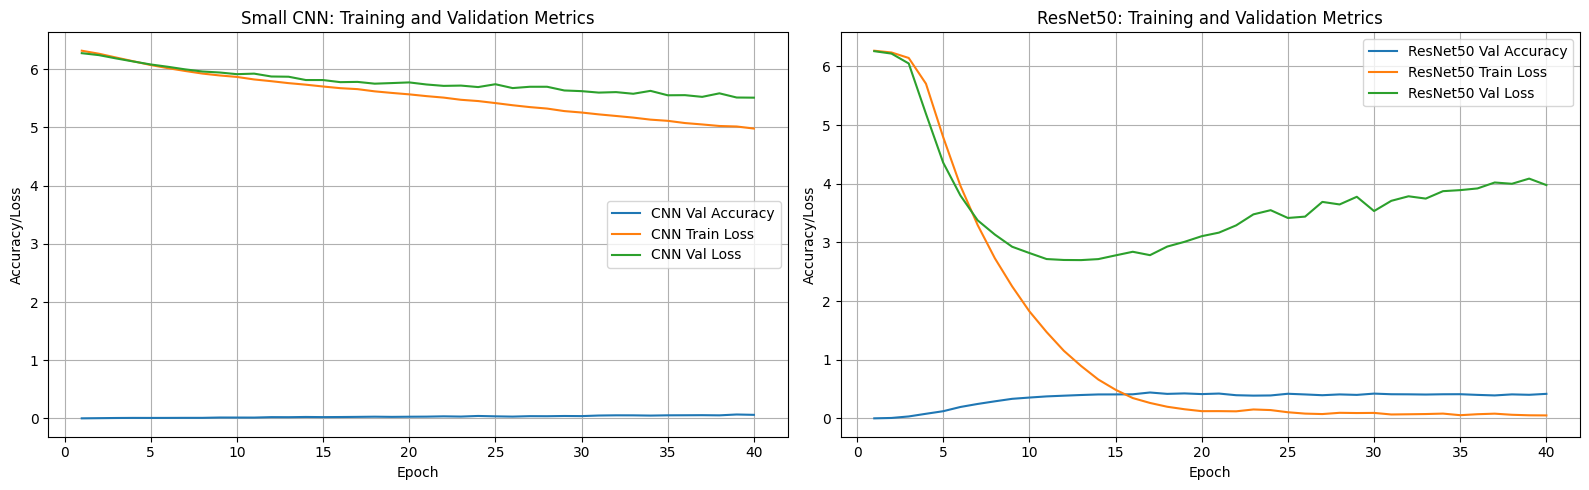

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot for ResNet50 (if history is available)
if history_resnet["epoch"]:
    axes[1].plot(history_resnet["epoch"], history_resnet["val_acc"], label="ResNet50 Val Accuracy")
    axes[1].plot(history_resnet["epoch"], history_resnet["train_loss"], label="ResNet50 Train Loss")
    axes[1].plot(history_resnet["epoch"], history_resnet["val_loss"], label="ResNet50 Val Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy/Loss")
    axes[1].set_title("ResNet50: Training and Validation Metrics")
    axes[1].legend()
    axes[1].grid(True)
else:
    axes[1].text(0.5, 0.5, "ResNet50 training was interrupted.", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title("ResNet50: Training and Validation Metrics")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [1]:
#@title Setup for TPU
print("Installing torch_xla and torchvision...")
!pip install torch_xla torchvision -f https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl

import torch_xla.core.xla_model as xm
import torch

# Configure the device
try:
    # Attempt to get TPU device
    device = xm.xla_device()
    print(f"Device: {device} (TPU)")
except RuntimeError:
    # Fallback to CUDA if TPU is not available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Device: {device} (CUDA)")
    else:
        # Fallback to CPU if neither TPU nor CUDA is available
        device = torch.device("cpu")
        print(f"Device: {device} (CPU)")

# Verify device setup
print(f"Current device: {device}")

Installing torch_xla and torchvision...
Looking in links: https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl


/tmp/ipython-input-712673675.py:10: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


Device: xla:0 (TPU)
Current device: xla:0


In [50]:
#@title ResNet50 TPU
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.runtime as runtime # Added import for runtime
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch
from torch import nn
from typing import Dict, List, Tuple, Optional
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import pandas as pd
import os

!pip -q install timm
import timm

# Helper function
def create_warmup_scheduler(optimizer, warmup_steps: int):
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0
    return LambdaLR(optimizer, lr_lambda)

# Hyperparameters
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000

# Paths
BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
metadata_path = os.path.join(BASE_PATH, "reptilia_dataset_processed.csv")

df = pd.read_csv(metadata_path)
df["label_id"], label_names = pd.factorize(df["species"])
num_classes = len(label_names)

train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

train_df = train_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
val_df = val_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
test_df = test_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)

import torchvision.transforms as T
from PIL import Image

class ReptiliaDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["image_path_fixed"]
        label = int(row["label_id"])
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
             # Fallback for corrupted images or path issues, though dropna should have caught NaNs
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224))

        if self.transform is not None:
            img = self.transform(img)

        return img, label

image_size = 224

train_transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

requested_batch_size = 64

flags = {
    "EPOCHS": EPOCHS,
    "LR": LR,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "WARMUP_STEPS": WARMUP_STEPS,
    "num_classes": num_classes,
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "train_transform": train_transform,
    "val_transform": val_transform,
    "ReptiliaDataset": ReptiliaDataset,
    "requested_batch_size": requested_batch_size,
    "create_warmup_scheduler": create_warmup_scheduler,
}

def _mp_fn(index, flags):
    EPOCHS = flags["EPOCHS"]
    LR = flags["LR"]
    WEIGHT_DECAY = flags["WEIGHT_DECAY"]
    WARMUP_STEPS = flags["WARMUP_STEPS"]
    num_classes = flags["num_classes"]
    train_df = flags["train_df"]
    val_df = flags["val_df"]
    test_df = flags["test_df"]
    train_transform = flags["train_transform"]
    val_transform = flags["val_transform"]
    ReptiliaDataset = flags["ReptiliaDataset"]
    BATCH_SIZE_PER_CORE = flags["requested_batch_size"]
    create_warmup_scheduler = flags["create_warmup_scheduler"]

    device = xm.xla_device()
    print(f"[{index}] Device: {device}")

    xm.rendezvous("init_dist_resnet_tpu")

    train_dataset = ReptiliaDataset(train_df, transform=train_transform)
    val_dataset = ReptiliaDataset(val_df, transform=val_transform)
    test_dataset = ReptiliaDataset(test_df, transform=val_transform)

    # Use pl.MpDeviceLoader from parallel_loader
    train_loader = pl.MpDeviceLoader(
        DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=True,
            num_workers=0,
            drop_last=True
        ),
        device=device
    )

    val_loader = pl.MpDeviceLoader(
        DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    test_loader = pl.MpDeviceLoader(
        DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    if runtime.global_ordinal() == 0: # Changed xm.get_ordinal() to runtime.global_ordinal()
        print(f"[{index}] Dataloader batches (per core): Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

    def train_one_epoch_xla(model, loader, optimizer, scheduler, epoch, total_steps_done, device, use_bf16=True):
        model.train()
        running_loss = 0.0
        n_batches = 0

        # MpDeviceLoader handles device placement; iterate directly
        for images, labels in tqdm(loader, desc=f"[{index}] Train Epoch {epoch}", disable=(runtime.global_ordinal() != 0)): # Changed xm.get_ordinal()
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            xm.optimizer_step(optimizer)

            if scheduler is not None:
                scheduler.step()

            running_loss += loss.item()
            n_batches += 1
            total_steps_done += 1

        reduced_running_loss = xm.mesh_reduce('train_loss_reduce', running_loss, np.sum)
        reduced_n_batches = xm.mesh_reduce('train_batches_reduce', n_batches, np.sum)
        avg_loss = reduced_running_loss / max(1, reduced_n_batches)

        if runtime.global_ordinal() == 0: # Changed xm.get_ordinal()
            print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
        return total_steps_done, avg_loss

    @torch.no_grad()
    def evaluate_xla(model, loader, device):
        model.eval()
        all_preds = []
        all_labels = []
        total_loss = 0.0
        num_batches = 0

        for images, labels in tqdm(loader, desc=f"[{index}] Eval", disable=(runtime.global_ordinal() != 0)): # Changed xm.get_ordinal()
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            total_loss += loss.item()
            num_batches += 1

        reduced_total_loss = xm.mesh_reduce("eval_loss_reduce", total_loss, np.sum)
        reduced_num_batches = xm.mesh_reduce("eval_batches_reduce", num_batches, np.sum)

        all_preds_tensor = torch.tensor(all_preds, device=device)
        all_labels_tensor = torch.tensor(all_labels, device=device)
        global_all_preds = xmp.all_gather(all_preds_tensor).cpu().numpy()
        global_all_labels = xmp.all_gather(all_labels_tensor).cpu().numpy()

        acc = accuracy_score(global_all_labels, global_all_preds)
        avg_loss = reduced_total_loss / max(1, reduced_num_batches)
        return acc, avg_loss

    model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = create_warmup_scheduler(optimizer, warmup_steps=WARMUP_STEPS)

    history = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}
    global_step = 0

    for epoch in range(1, EPOCHS + 1):
        global_step, train_loss = train_one_epoch_xla(
            model, train_loader, optimizer, scheduler, epoch, total_steps_done=global_step, device=device, use_bf16=True
        )
        val_acc, val_loss = evaluate_xla(model, val_loader, device)

        history["epoch"].append(epoch)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)
        history["train_loss"].append(train_loss)

        if runtime.global_ordinal() == 0: # Changed xm.get_ordinal()
            print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

    if runtime.global_ordinal() == 0: # Changed xm.get_ordinal()
        return history

print("Launching ResNet50 training on TPU cores...")
history_resnet_tpu = xmp.spawn(_mp_fn, args=(flags,), nprocs=len(xm.get_xla_supported_devices()))
print("TPU training complete.")

Launching ResNet50 training on TPU cores...
[0] Device: xla:0
[0] Dataloader batches (per core): Train=216, Val=31, Test=28


/tmp/ipython-input-220077951.py:128: DeprecationWarning:

Use torch_xla.device instead



[0] Train Epoch 1:   0%|          | 0/216 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning:

Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")



Error loading /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia/processed_chunks_0019/337151.jpg: [Errno 5] Input/output error: '/content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia/processed_chunks_0019/337151.jpg'


KeyboardInterrupt: 